In [1]:
import numpy as np
import matplotlib.pyplot as plt
import OpenVisus as ov
import cartopy.crs as ccrs
import cartopy.feature as cfeature

try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm
    print("Using regular tqdm instead of notebook version")
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Set up environment
import os
os.environ['VISUS_CACHE'] = "./visus_can_be_deleted"

In [16]:
def load_temperature_dataset():
    """
    Load the theta (temperature) dataset and return the database object
    """
    variable = 'theta'
    field = f"https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_{variable}/llc2160_{variable}.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
    
    db = ov.LoadDataset(field)
    print(f'Dimensions: {db.getLogicBox()[1][0]}*{db.getLogicBox()[1][1]}*{db.getLogicBox()[1][2]}')
    print(f'Total Timesteps: {len(db.getTimesteps())}')
    print(f'Field: {db.getField().name}')
    print('Data Type: float32')
    
    return db

In [18]:
def read_temperature_data(db, timestep=0, resolution=-15):
    """
    Read temperature data for a specific timestep
    
    Parameters:
    db (ov.Dataset): OpenVisus dataset object
    timestep (int): Timestep to read
    resolution (int): Resolution level (-15 to 0)
    
    Returns:
    np.ndarray: Temperature data
    """
    data = db.read(time=timestep, quality=resolution)
    print(f"Data shape: {data.shape}")
    print(f"Data min: {np.nanmin(data)}, max: {np.nanmax(data)}")
    
    # If data is 3D (has depth dimension), return the surface layer
    if len(data.shape) == 3:
        return data[0]  # First depth level (surface)
    else:
        return data

In [19]:
def visualize_temperature(data, vmin=0, vmax=33, cmap='turbo', title='Sea Surface Temperature (Theta)', 
                          save_path='temperature_visualization.png'):
    """
    Create and save a visualization of temperature data
    
    Parameters:
    data (np.ndarray): Temperature data array
    vmin (float): Minimum value for colormap
    vmax (float): Maximum value for colormap
    cmap (str): Matplotlib colormap name
    title (str): Plot title
    save_path (str): Path to save the visualization
    """
    plt.figure(figsize=(12, 8))
    
    # Create the plot with temperature colormap
    im = plt.imshow(data, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add colorbar
    cbar = plt.colorbar(im, label='Temperature (°C)')
    
    # Add title
    plt.title(title)
    
    # Save the figure
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"Visualization saved as '{save_path}'")

In [43]:
def visualize_indian_ocean_region(data, y_slice=(0.45, 0.71), x_slice=(0.2, 0.6), 
                                 vmin=0, vmax=33, cmap='turbo', 
                                 title='Indian Ocean Region Sea Surface Temperature',
                                 save_path='indian_ocean_temperature.png'):
    """
    Create and save a visualization focused on the Indian Ocean region
    
    Parameters:
    data (np.ndarray): Full temperature data array
    y_slice (tuple): Relative start and end points for y-axis (0-1)
    x_slice (tuple): Relative start and end points for x-axis (0-1)
    vmin (float): Minimum value for colormap
    vmax (float): Maximum value for colormap
    cmap (str): Matplotlib colormap name
    title (str): Plot title
    save_path (str): Path to save the visualization
    """
    # Calculate region boundaries
    y_start = int(data.shape[0] * y_slice[0])
    y_end = int(data.shape[0] * y_slice[1])
    x_start = int(data.shape[1] * x_slice[0])
    x_end = int(data.shape[1] * x_slice[1])
    
    # Extract the region of interest
    region_data = data[y_start:y_end, x_start:x_end]
    
    # Create the visualization
    plt.figure(figsize=(12, 8))
    
    # Create the plot with temperature colormap
    im = plt.imshow(region_data, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add colorbar
    cbar = plt.colorbar(im, label='Temperature (°C)')
    
    # Add title
    plt.title(title)
    
    # Save the figure
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"Focused visualization saved as '{save_path}'")

In [44]:
# Load the dataset
db = load_temperature_dataset()

# Read temperature data for timestep 0
temp_data = read_temperature_data(db, timestep=0, resolution=-15)

# Create a visualization of the full dataset
visualize_temperature(temp_data)

# Create a visualization focused on the Indian Ocean region
visualize_indian_ocean_region(temp_data)

# To create visualizations for multiple timesteps:
for ts in range(0, 10, 2):  # Every 2nd timestep from 0 to 8
    temp_data = read_temperature_data(db, timestep=ts, resolution=-15)
    visualize_temperature(temp_data, save_path=f'temperature_ts_{ts}.png', 
                         title=f'Sea Surface Temperature - Timestep {ts}')

Dimensions: 8640*6480*90
Total Timesteps: 10366
Field: theta
Data Type: float32
Data shape: (3, 203, 270)
Data min: -2.0670995712280273, max: 32.04000473022461
Visualization saved as 'temperature_visualization.png'
Focused visualization saved as 'indian_ocean_temperature.png'
Data shape: (3, 203, 270)
Data min: -2.0670995712280273, max: 32.04000473022461
Visualization saved as 'temperature_ts_0.png'
Data shape: (3, 203, 270)
Data min: -1.9001495838165283, max: 32.023048400878906
Visualization saved as 'temperature_ts_2.png'
Data shape: (3, 203, 270)
Data min: -1.8998700380325317, max: 32.111610412597656
Visualization saved as 'temperature_ts_4.png'
Data shape: (3, 203, 270)
Data min: -1.899095058441162, max: 32.301326751708984
Visualization saved as 'temperature_ts_6.png'
Data shape: (3, 203, 270)
Data min: -1.899330735206604, max: 32.486572265625
Visualization saved as 'temperature_ts_8.png'


In [4]:
# Define the time range (January 20, 2020 to March 24, 2021)
start_date = datetime(2020, 1, 20)
end_date = datetime(2021, 3, 24)
total_days = (end_date - start_date).days
hours_per_day = 24
total_timesteps = total_days * hours_per_day

# Create date range for plotting
date_range = [start_date + timedelta(hours=i) for i in range(total_timesteps)]

# Define IOD regions (based on the standard definition)
# Western IOD region: 50°E to 70°E and 10°S to 10°N


# Eastern IOD region: 90°E to 110°E and 10°S to 0°S

In [5]:
# Function to extract regional SST (Sea Surface Temperature) at a specified depth
def extract_regional_sst(timestep, region, depth_level=0, resolution=-9):
    """
    Extract SST data for a specific region and timestep
    
    Parameters:
    timestep (int): The timestep to extract data for
    region (str): 'west' or 'east' to specify the IOD region
    depth_level (int): Depth level to extract (0 for surface)
    resolution (int): Data resolution (-15 to 0, with 0 being highest resolution)
    
    Returns:
    float: Average SST for the specified region
    """
    if region == 'west':
        x_range = (int(db.getLogicBox()[1][0] * 0.23), int(db.getLogicBox()[1][0] * 0.32))
        y_range = (int(db.getLogicBox()[1][1] * 0.52), int(db.getLogicBox()[1][1] * 0.70))
    else:  # east
        # Eastern IOD region: 90°E to 110°E and 10°S to 0°S
        # Convert to grid coordinates (this will need adjustment based on your dataset)
        x_range = (int(db.getLogicBox()[1][0] * 0.35), int(db.getLogicBox()[1][0] * 0.53))
        y_range = (int(db.getLogicBox()[1][1] * 0.52), int(db.getLogicBox()[1][1] * 0.70))
    
    # Read data for the specific region
    data = db.read(
        time=timestep, 
        quality=resolution,
        x=x_range,
        y=y_range,
        z=(depth_level, depth_level+1)
    )
    
    # Calculate average temperature for the region
    return np.nanmean(data)

In [8]:
# Function to create spatial map for a specific timestep
def create_spatial_map(timestep, resolution=-9, depth_level=0):
    """
    Create a spatial map showing SST for the Indian Ocean region
    
    Parameters:
    timestep (int): The timestep to visualize
    resolution (int): Data resolution (-15 to 0, with 0 being highest resolution)
    depth_level (int): Depth level to extract (0 for surface)
    """
    # Define Indian Ocean region (approximately)
    # The exact coordinates will need adjustment based on your dataset
    x_range = (int(db.getLogicBox()[1][0] * 0.23), int(db.getLogicBox()[1][0] * 0.53))
    y_range = (int(db.getLogicBox()[1][1] * 0.52), int(db.getLogicBox()[1][1] * 0.70))
    
    # Read data for the Indian Ocean region
    data = db.read(
        time=timestep, 
        quality=resolution,
        x=x_range,
        y=y_range,
        z=(depth_level, depth_level+1)
    )
    
    # Create a map
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # Create a mesh grid for plotting (this is approximate and will need adjustment)
    y_size, x_size = data.shape[0], data.shape[1]
    lons = np.linspace(50, 110, x_size)
    lats = np.linspace(-10, 10, y_size)
    
    # Create meshgrid
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    
    # Plot the data
    c = ax.pcolormesh(lon_grid, lat_grid, data[0], cmap='viridis', transform=ccrs.PlateCarree())
    
    # Add colorbar
    cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label('Sea Surface Temperature (°C)')
    
    # Draw IOD regions
    # Western IOD region (50°E to 70°E and 10°S to 10°N)
    ax.plot([50, 70, 70, 50, 50], [10, 10, -10, -10, 10], 'r-', transform=ccrs.PlateCarree(), label='Western IOD Region')
    
    # Eastern IOD region (90°E to 110°E and 10°S to 0°S)
    ax.plot([90, 110, 110, 90, 90], [0, 0, -10, -10, 0], 'b-', transform=ccrs.PlateCarree(), label='Eastern IOD Region')
    
    # Add title with timestamp
    current_date = start_date + timedelta(hours=timestep)
    plt.title(f'Sea Surface Temperature - {current_date.strftime("%Y-%m-%d %H:%M")}')
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    # Add legend
    plt.legend(loc='lower left')
    
    # Save the figure
    plt.savefig(f'sst_map_timestep_{timestep}.png')
    plt.close()

Creating spatial maps for sample timesteps...


  0%|          | 0/5 [00:00<?, ?it/s]

TypeError: Dimensions of C (145, 324) should be one smaller than X(145) and Y(1) while using shading='flat' see help(pcolormesh)

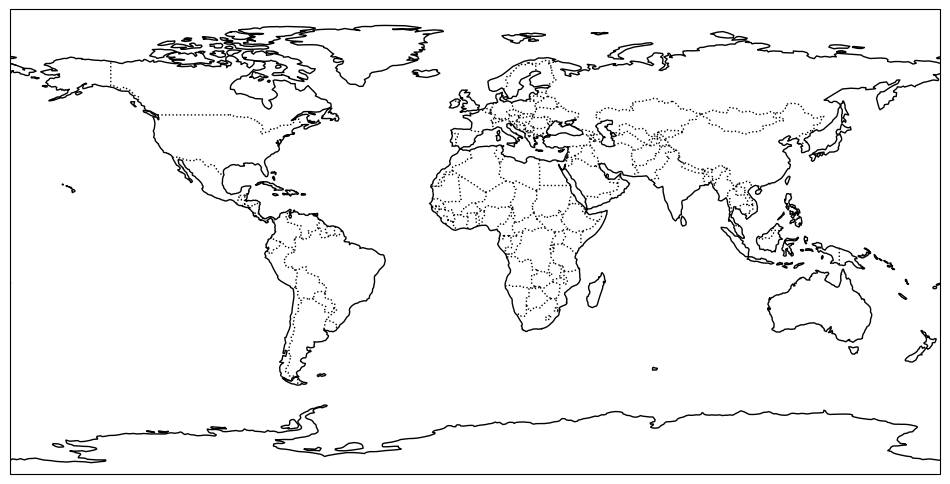

In [9]:
# Create spatial maps for some sample timesteps
sample_timesteps = range(0, min(len(db.getTimesteps()), 100), 5)

print("Creating spatial maps for sample timesteps...")
for ts in tqdm(sample_timesteps[:5]):  # Just create maps for the first 5 sample timesteps
    create_spatial_map(ts)